<a href="https://colab.research.google.com/github/Polyakri/projects/blob/main/MachineLearningProjects/Evaluation_Metrics/Ex_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ex-4

Polydoros Akritidis

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

I 'd like to use this table.

In [ ]:
!pip install prettytable
from prettytable import PrettyTable

In [ ]:
df = pd.read_csv("Weather_Data.csv")
df

,Date/Time,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,1/1/2012 0:00,-1.8,-3.9,86,4,8.0,101.24,Fog
1,1/1/2012 1:00,-1.8,-3.7,87,4,8.0,101.24,Fog
2,1/1/2012 2:00,-1.8,-3.4,89,7,4.0,101.26,"Freezing Drizzle,Fog"
3,1/1/2012 3:00,-1.5,-3.2,88,6,4.0,101.27,"Freezing Drizzle,Fog"
4,1/1/2012 4:00,-1.5,-3.3,88,7,4.8,101.23,Fog
...,...,...,...,...,...,...,...,...
8779,12/31/2012 19:00,0.1,-2.7,81,30,9.7,100.13,Snow
8780,12/31/2012 20:00,0.2,-2.4,83,24,9.7,100.03,Snow
8781,12/31/2012 21:00,-0.5,-1.5,93,28,4.8,99.95,Snow
8782,12/31/2012 22:00,-0.2,-1.8,89,28,9.7,99.91,Snow


Convert the data into the correct format

In [ ]:
#Convert the Date/Time into datetime
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

df[['Date', 'Time']] = df['Date/Time'].astype(str).str.split(expand=True)

df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Month'] = pd.to_datetime(df['Date']).dt.month

#Add pa Season column
df['Season'] = np.nan

#Check the Month to add the season
df.loc[df['Month'].isin([1, 2, 12]), 'Season'] = 1
df.loc[df['Month'].isin([3, 4, 5]), 'Season'] = 2
df.loc[df['Month'].isin([6, 7, 8]), 'Season'] = 3
df.loc[df['Month'].isin([9, 10, 11]), 'Season'] = 0

#Subtrack -1 from every month
df['Month'] = df['Month'] - 1

#Put them on the start of the dataframe
df = df[['Month', 'Hour', 'Date', 'Season'] + [col for col in df.columns if col not in ['Month', 'Hour', 'Date', 'Season']]]


df = df.drop(columns=['Date/Time', 'Time', 'Date'])


Split the Weather to the two values and keep only the first

In [ ]:
df[['Weather1', 'Weather2']] = df['Weather'].str.split(',', 1, expand=True)
df = df.drop(columns=['Weather', 'Weather2'])

<ipython-input-81-e530c044f92c>:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['Weather1', 'Weather2']] = df['Weather'].str.split(',', 1, expand=True)


Check the unique values of the Weather column so we can see how to transform them

In [ ]:
df = df.rename(columns={'Weather1': 'Weather'})

unique_values = df['Weather'].value_counts()

print(unique_values)

Mainly Clear        2106
Mostly Cloudy       2069
Cloudy              1728
Clear               1326
Snow                 457
Rain                 450
Rain Showers         191
Fog                  150
Drizzle              139
Snow Showers          64
Freezing Drizzle      27
Thunderstorms         27
Freezing Rain         22
Haze                  16
Moderate Snow          6
Freezing Fog           4
Snow Pellets           1
Moderate Rain          1
Name: Weather, dtype: int64


Keep only the needed values by transforming the feature of the weather into just weather

In [ ]:
df['Weather'] = df['Weather'].replace('Mainly Clear', 'Clear')
df['Weather'] = df['Weather'].replace('Mostly Cloudy', 'Cloudy')
df['Weather'] = df['Weather'].replace('Rain Showers', 'Rain')
df['Weather'] = df['Weather'].replace('Snow Showers', 'Snow')
df['Weather'] = df['Weather'].replace('Freezing Drizzle', 'Drizzle')
df['Weather'] = df['Weather'].replace('Freezing Rain', 'Rain')
df['Weather'] = df['Weather'].replace('Moderate Snow', 'Snow')
df['Weather'] = df['Weather'].replace('Freezing Fog', 'Fog')
df['Weather'] = df['Weather'].replace('Snow Pellets', 'Snow')
df['Weather'] = df['Weather'].replace('Moderate Rain', 'Rain')

Check if it worked

In [ ]:
unique_values = df['Weather'].value_counts()

print(unique_values)

Cloudy           3797
Clear            3432
Rain              664
Snow              528
Drizzle           166
Fog               154
Thunderstorms      27
Haze               16
Name: Weather, dtype: int64


Check if there are nan or duplcate values in the dataset

In [ ]:
nan_count = df.isna().sum().sum()
num_duplicates = df.duplicated().sum()
# Print the count of NaN values for each column
print(nan_count)
print(num_duplicates)

0
0


No Nan or duplicate values so no need to drop

#Data Analysis

Print the dataframe

In [ ]:
df

,Month,Hour,Season,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
0,0,0,1.0,-1.8,-3.9,86,4,8.0,101.24,Fog
1,0,1,1.0,-1.8,-3.7,87,4,8.0,101.24,Fog
2,0,2,1.0,-1.8,-3.4,89,7,4.0,101.26,Drizzle
3,0,3,1.0,-1.5,-3.2,88,6,4.0,101.27,Drizzle
4,0,4,1.0,-1.5,-3.3,88,7,4.8,101.23,Fog
...,...,...,...,...,...,...,...,...,...,...
8779,11,19,1.0,0.1,-2.7,81,30,9.7,100.13,Snow
8780,11,20,1.0,0.2,-2.4,83,24,9.7,100.03,Snow
8781,11,21,1.0,-0.5,-1.5,93,28,4.8,99.95,Snow
8782,11,22,1.0,-0.2,-1.8,89,28,9.7,99.91,Snow


Describe the dataset

In [ ]:
df.describe()

,Month,Hour,Season,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,5.513661,11.500000,1.505464,8.798144,2.555294,67.431694,14.945469,27.664447,101.051623
std,3.451430,6.922581,1.118084,11.687883,10.883072,16.918881,8.688696,12.622688,0.844005
min,0.000000,0.000000,0.000000,-23.300000,-28.500000,18.000000,0.000000,0.200000,97.520000
25%,3.000000,5.750000,1.000000,0.100000,-5.900000,56.000000,9.000000,24.100000,100.560000
50%,6.000000,11.500000,2.000000,9.300000,3.300000,68.000000,13.000000,25.000000,101.070000
75%,9.000000,17.250000,3.000000,18.800000,11.800000,81.000000,20.000000,25.000000,101.590000
max,11.000000,23.000000,3.000000,33.000000,24.400000,100.000000,83.000000,48.300000,103.650000


Plot the histogram of the values in the Temp C column

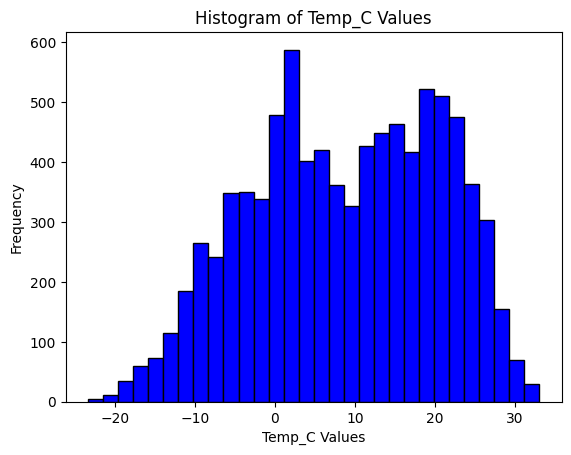

In [ ]:
plt.hist(df['Temp_C'], bins=30, color='blue', edgecolor='black')

plt.xlabel('Temp_C Values')
plt.ylabel('Frequency')
plt.title('Histogram of Temp_C Values')

plt.show()

This is not a known distribution, but we can say that looks like Normal Distribution

Plot both the histogram and the normal distribution in the same plot

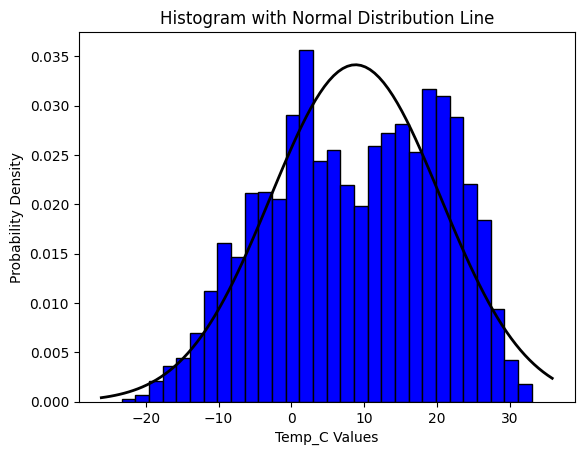

In [ ]:
plt.hist(df['Temp_C'], bins=30, color='blue', edgecolor='black', density=True)  # density=True for probability density


mean_temp = df['Temp_C'].mean()
std_temp = df['Temp_C'].std()


xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_temp, std_temp)


plt.plot(x, p, 'k', linewidth=2)

plt.xlabel('Temp_C Values')
plt.ylabel('Probability Density')
plt.title('Histogram with Normal Distribution Line')

plt.show()


Plot a bar plot with the count of the weather values

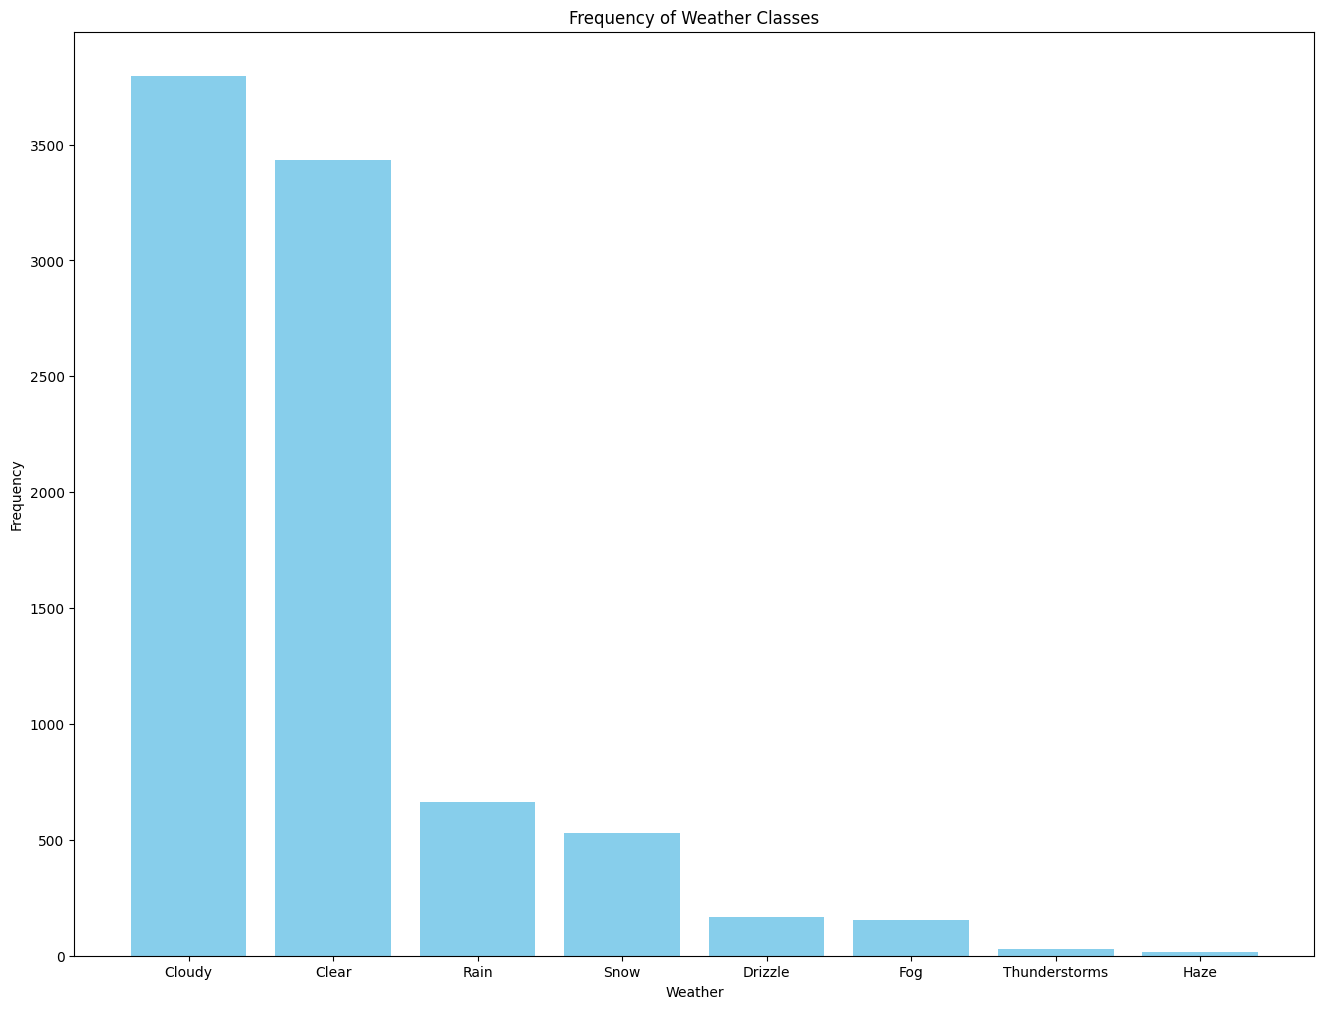

In [ ]:
weather_counts = df['Weather'].value_counts()

# Create a bar plot
plt.figure(figsize=(16, 12))
plt.bar(weather_counts.index, weather_counts.values, color='skyblue')

# Add labels and title
plt.xlabel('Weather')
plt.ylabel('Frequency')
plt.title('Frequency of Weather Classes')

# Show the plot
plt.show()

As we can see from the diagram and earlier on data manipulation, there is big difference in the number of appearances of the weather conditions, therefore the dataset is imbalanced.

#Temperature Prediction

One hot Encode

In [ ]:
dummies = pd.get_dummies(df['Weather'])
res = pd.concat([df, dummies], axis=1)
df_new = res.drop(columns=['Weather'])
df_new

,Month,Hour,Season,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Clear,Cloudy,Drizzle,Fog,Haze,Rain,Snow,Thunderstorms
0,0,0,1.0,-1.8,-3.9,86,4,8.0,101.24,0,0,0,1,0,0,0,0
1,0,1,1.0,-1.8,-3.7,87,4,8.0,101.24,0,0,0,1,0,0,0,0
2,0,2,1.0,-1.8,-3.4,89,7,4.0,101.26,0,0,1,0,0,0,0,0
3,0,3,1.0,-1.5,-3.2,88,6,4.0,101.27,0,0,1,0,0,0,0,0
4,0,4,1.0,-1.5,-3.3,88,7,4.8,101.23,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8779,11,19,1.0,0.1,-2.7,81,30,9.7,100.13,0,0,0,0,0,0,1,0
8780,11,20,1.0,0.2,-2.4,83,24,9.7,100.03,0,0,0,0,0,0,1,0
8781,11,21,1.0,-0.5,-1.5,93,28,4.8,99.95,0,0,0,0,0,0,1,0
8782,11,22,1.0,-0.2,-1.8,89,28,9.7,99.91,0,0,0,0,0,0,1,0


Split the dataset into features and target

In [ ]:
target_column = "Temp_C"
y = df_new[target_column].to_numpy()

dataset_rows = y.shape[0]

fn= df_new.drop(columns=target_column)
feature_names=fn.columns
x = df_new.drop(columns= target_column).to_numpy()

Scale the data with Max Abs Scaler

In [ ]:
scaler = MaxAbsScaler()

x = scaler.fit_transform(x)

Split the dataset into train, test and validation set


In [ ]:
x_train, x_2, y_train, y_2 = train_test_split(x, y, test_size=0.3, random_state=0)
x_test, x_val, y_test, y_val = train_test_split (x_2, y_2, test_size =2/3,random_state=0 )

Train A Knn Regressor

In [ ]:
k_values = [5,15,25,35,45,55,65,75,85,95]
results = {'k': [], 'Mean Absolute Error': []}

for k in k_values:
    knn_regressor = KNeighborsRegressor(n_neighbors=k, weights='distance')

    knn_regressor.fit(x_train, y_train)


    y_val_pred = knn_regressor.predict(x_val)

    # Evaluate the model
    mae = mean_absolute_error(y_val, y_val_pred)

    # Store results
    results['k'].append(k)
    results['Mean Absolute Error'].append(mae)

# Create a table and print the results
table = PrettyTable(['k', 'Mean Absolute Error'])
for i in range(len(k_values)):
    table.add_row([results['k'][i], results['Mean Absolute Error'][i]])

print(table)

+----+---------------------+
| k  | Mean Absolute Error |
+----+---------------------+
| 5  |  0.9383840006815409 |
| 15 |  1.1935642063798042 |
| 25 |  1.376679038455953  |
| 35 |  1.5186526788120442 |
| 45 |  1.622382295110998  |
| 55 |  1.7251094925323602 |
| 65 |  1.8109205854629022 |
| 75 |  1.9030419663954345 |
| 85 |  1.9924152812359337 |
| 95 |  2.0673994443426325 |
+----+---------------------+


Combine train set with validate set

In [ ]:
x_train_combined = np.concatenate((x_train, x_val), axis=0)

y_train_combined = np.concatenate((y_train, y_val), axis=0)

For the best K calculate MAE, R2 and STD

In [ ]:
knn_regressor = KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_regressor.fit(x_train_combined, y_train_combined)


y_combined_pred = knn_regressor.predict(x_test)

mae = mean_absolute_error(y_combined_pred, y_test)
r2 = r2_score(y_test, y_combined_pred)
std_dev = np.std(y_test - y_combined_pred)

print(f'Mean Absolute Error: {mae}')
print(f'R2 Score: {r2}')
print(f'Standard Deviation: {std_dev}')

Mean Absolute Error: 0.8237349803800774
R2 Score: 0.9876925564713954
Standard Deviation: 1.2816328147384484


5k fold validation

In [ ]:
results_5c = {'k': [], 'Mean Absolute Error': []}
x_combined = np.concatenate((x_train, x_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)


for k in k_values:
     knn = KNeighborsRegressor(n_neighbors=k, weights = 'distance')
     cv_scores = cross_val_score(knn, x_combined, y_combined, cv=5, scoring='neg_mean_absolute_error')
     results_5c['k'].append(k)
     results_5c['Mean Absolute Error'].append(-cv_scores.mean())

results_5c

{'k': [5, 15, 25, 35, 45, 55, 65, 75, 85, 95],
 'Mean Absolute Error': [0.9243842686014091,
  1.1898953025843897,
  1.3866830166759232,
  1.5403164653564982,
  1.6679039091868837,
  1.7748874172102052,
  1.8710663390871551,
  1.9539480614345883,
  2.0329616787443414,
  2.10282571109673]}

The best K is 5. Let's calculate the MAE in the Test set.

In [ ]:
knn = KNeighborsRegressor(n_neighbors=5, weights = 'distance')

knn.fit(x_combined,y_combined)

y_test_pred = knn.predict (x_test)

mae_test = mean_absolute_error (y_test, y_test_pred)

print(f"Mean absolute error in the test set is {mae_test}")

min_index = results_5c['Mean Absolute Error'].index(min(results_5c['Mean Absolute Error']))
min_k_value = results_5c['k'][min_index]

print(f'Mean Absolute Error in 5k cross validation {min(results_5c["Mean Absolute Error"])}')



Mean absolute error in the test set is 0.8237349803800774
Mean Absolute Error in 5k cross validation 0.9243842686014091


As we can see the Mean Absolute Error in test set is lower than the 5k cross validation. This might happen because the data in the test set is easier to predict. Also the test set is significantly lower than the validation set in 5k cross validation. Meaning less "outliers" in the set or chance of them to appear.

Find the difference between the 5k fold cross validation and without it

In [ ]:
print("Mean Absolute Error:")
for k, val1, val2 in zip(results['k'], results['Mean Absolute Error'], results_5c['Mean Absolute Error']):
    diff = abs(val1 - val2)
    print(f"{k}: {val1}   {val2}   Difference: {diff}")

Mean Absolute Error:
5: 0.9383840006815409   0.9243842686014091   Difference: 0.013999732080131833
15: 1.1935642063798042   1.1898953025843897   Difference: 0.003668903795414513
25: 1.376679038455953   1.3866830166759232   Difference: 0.010003978219970122
35: 1.5186526788120442   1.5403164653564982   Difference: 0.021663786544454
45: 1.622382295110998   1.6679039091868837   Difference: 0.04552161407588562
55: 1.7251094925323602   1.7748874172102052   Difference: 0.04977792467784492
65: 1.8109205854629022   1.8710663390871551   Difference: 0.060145753624252896
75: 1.9030419663954345   1.9539480614345883   Difference: 0.050906095039153776
85: 1.9924152812359337   2.0329616787443414   Difference: 0.04054639750840772
95: 2.0673994443426325   2.10282571109673   Difference: 0.03542626675409766


#Weather Prediction

Filter the dataset that it has only clear or snow weather

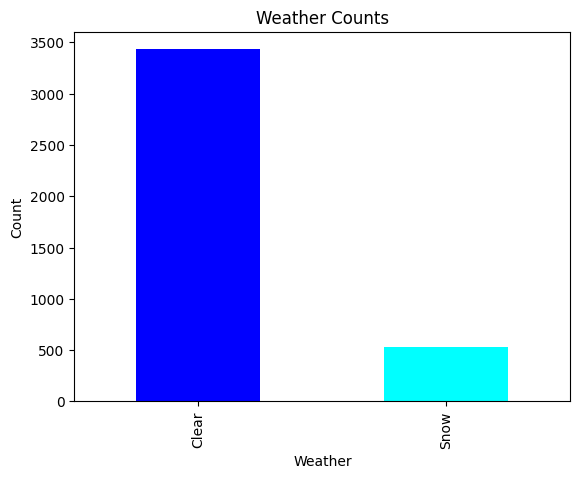

In [ ]:
df_filtered = df[df['Weather'].isin(['Clear', 'Snow'])]

weather_counts = df_filtered['Weather'].value_counts()

# Plotting the bar chart
weather_counts.plot(kind='bar', color=['blue', 'cyan'])
plt.title('Weather Counts')
plt.xlabel('Weather')
plt.ylabel('Count')
plt.show()

In [ ]:
df_filtered.head()

,Month,Hour,Season,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
36,0,12,1.0,1.7,-6.2,56,48,24.1,99.21,Clear
41,0,17,1.0,-2.1,-9.5,57,22,25.0,99.66,Snow
44,0,20,1.0,-5.6,-13.4,54,24,25.0,100.07,Snow
45,0,21,1.0,-5.8,-12.8,58,26,25.0,100.15,Snow
47,0,23,1.0,-7.4,-14.1,59,17,19.3,100.27,Snow


Replace the Clear with 1 and snow with 0

In [ ]:
df_filtered

,Month,Hour,Season,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
36,0,12,1.0,1.7,-6.2,56,48,24.1,99.21,Clear
41,0,17,1.0,-2.1,-9.5,57,22,25.0,99.66,Snow
44,0,20,1.0,-5.6,-13.4,54,24,25.0,100.07,Snow
45,0,21,1.0,-5.8,-12.8,58,26,25.0,100.15,Snow
47,0,23,1.0,-7.4,-14.1,59,17,19.3,100.27,Snow
...,...,...,...,...,...,...,...,...,...,...
8779,11,19,1.0,0.1,-2.7,81,30,9.7,100.13,Snow
8780,11,20,1.0,0.2,-2.4,83,24,9.7,100.03,Snow
8781,11,21,1.0,-0.5,-1.5,93,28,4.8,99.95,Snow
8782,11,22,1.0,-0.2,-1.8,89,28,9.7,99.91,Snow


In [ ]:
df_filtered.loc[:, 'Weather1'] = df_filtered['Weather'].replace({'Clear': 0, 'Snow': 1})
df_filtered.drop(columns='Weather', inplace=True)
df_filtered = df_filtered.rename(columns={'Weather1': 'Weather'})
df_filtered

<ipython-input-104-32b82e2143d7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'Weather1'] = df_filtered['Weather'].replace({'Clear': 0, 'Snow': 1})
<ipython-input-104-32b82e2143d7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns='Weather', inplace=True)


,Month,Hour,Season,Temp_C,Dew Point Temp_C,Rel Hum_%,Wind Speed_km/h,Visibility_km,Press_kPa,Weather
36,0,12,1.0,1.7,-6.2,56,48,24.1,99.21,0
41,0,17,1.0,-2.1,-9.5,57,22,25.0,99.66,1
44,0,20,1.0,-5.6,-13.4,54,24,25.0,100.07,1
45,0,21,1.0,-5.8,-12.8,58,26,25.0,100.15,1
47,0,23,1.0,-7.4,-14.1,59,17,19.3,100.27,1
...,...,...,...,...,...,...,...,...,...,...
8779,11,19,1.0,0.1,-2.7,81,30,9.7,100.13,1
8780,11,20,1.0,0.2,-2.4,83,24,9.7,100.03,1
8781,11,21,1.0,-0.5,-1.5,93,28,4.8,99.95,1
8782,11,22,1.0,-0.2,-1.8,89,28,9.7,99.91,1


Split the dataset into features and target

In [ ]:
target_column = "Weather"
y_weather = df_filtered[target_column].to_numpy()

dataset_rows = y_weather.shape[0]

fn_weather= df_filtered.drop(columns=target_column)
feature_names=fn.columns
x_weather = df_filtered.drop(columns= target_column).to_numpy()

Split the dataset into train and test set

In [ ]:
x_train_weather, x_test_weather, y_train_weather, y_test_weather = train_test_split(x_weather, y_weather, test_size=0.3, random_state=0)

Use MaxAbsScaler to Scale the data

In [ ]:
scaler = MaxAbsScaler()

scaler.fit(x_train_weather)

x_train_weather_scaled = scaler.transform(x_train_weather)
x_test_weather_scaled = scaler.transform(x_test_weather)

Train a knn classifier algorithm and add the metrics to a list.

In [ ]:
results = []

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_classifier.fit(x_train_weather_scaled, y_train_weather)
    y_pred_weather = knn_classifier.predict(x_test_weather_scaled)

    # Calculate metrics
    accuracy = accuracy_score(y_test_weather, y_pred_weather)
    precision = precision_score(y_test_weather, y_pred_weather)
    recall = recall_score(y_test_weather, y_pred_weather)
    f1 = f1_score(y_test_weather, y_pred_weather)



    # Add metrics to results list
    results.append([k, accuracy, precision, recall, f1])

# Print results with fancytable
table = PrettyTable(['k', 'Accuracy', 'Precision', 'Recall', 'F1'])
for result in results:
    table.add_row(result)

print(table)

+----+--------------------+--------------------+--------------------+--------------------+
| k  |      Accuracy      |     Precision      |       Recall       |         F1         |
+----+--------------------+--------------------+--------------------+--------------------+
| 5  | 0.9713804713804713 | 0.9727891156462585 | 0.8265895953757225 |      0.89375       |
| 15 | 0.9654882154882155 | 0.9925373134328358 | 0.7687861271676301 | 0.8664495114006514 |
| 25 | 0.9587542087542088 | 0.9769230769230769 | 0.7341040462427746 | 0.8382838283828384 |
| 35 | 0.9570707070707071 |     0.9765625      | 0.7225433526011561 | 0.8305647840531561 |
| 45 | 0.9562289562289562 | 0.991869918699187  | 0.7052023121387283 | 0.8243243243243242 |
| 55 | 0.9537037037037037 | 0.9916666666666667 | 0.6878612716763006 | 0.8122866894197953 |
| 65 | 0.952020202020202  | 0.9915254237288136 | 0.6763005780346821 | 0.8041237113402061 |
| 75 | 0.9503367003367004 | 0.9830508474576272 | 0.6705202312138728 | 0.7972508591065293 |

Due to the huge imbalance in the target count it is better to use f1 score. This takes into consideration both false positives and false negatives, making it more robust in imbalanced datasets.

If we want to heavily focus on the clear, the big one target then we want to minimize the false negatives we have to use recall

Use the stratify parameter to the train test split function.

In [ ]:
x_train_weather, x_test_weather, y_train_weather, y_test_weather = train_test_split(x_weather, y_weather, test_size=0.3,stratify = y_weather)

Scale the data with Max Abs Scaler

In [ ]:
scaler = MaxAbsScaler()

scaler.fit(x_train_weather)

x_train_weather_scaled = scaler.transform(x_train_weather)
x_test_weather_scaled = scaler.transform(x_test_weather)

Train the KNN classifier append the metrics to a results list and print the results.

In [ ]:
results_str = []

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_classifier.fit(x_train_weather_scaled, y_train_weather)
    y_pred_weather = knn_classifier.predict(x_test_weather)

    # Calculate metrics
    accuracy = accuracy_score(y_test_weather, y_pred_weather)
    precision = precision_score(y_test_weather, y_pred_weather)
    recall = recall_score(y_test_weather, y_pred_weather)
    f1 = f1_score(y_test_weather, y_pred_weather)



    # Add metrics to results list
    results_str.append([k, accuracy, precision, recall, f1])

# Print results with fancytable
table = PrettyTable(['k', 'Accuracy', 'Precision', 'Recall', 'F1'])
for result in results_str:
    table.add_row(result)

print(table)

+----+--------------------+--------------------+--------------------+--------------------+
| k  |      Accuracy      |     Precision      |       Recall       |         F1         |
+----+--------------------+--------------------+--------------------+--------------------+
| 5  | 0.9545454545454546 | 0.9814814814814815 | 0.6708860759493671 | 0.7969924812030076 |
| 15 | 0.9494949494949495 |        0.99        | 0.6265822784810127 | 0.7674418604651163 |
| 25 | 0.9486531986531986 |  0.98989898989899  | 0.620253164556962  | 0.7626459143968872 |
| 35 | 0.9478114478114478 | 0.9897959183673469 | 0.6139240506329114 | 0.7578125000000001 |
| 45 | 0.9478114478114478 | 0.9897959183673469 | 0.6139240506329114 | 0.7578125000000001 |
| 55 | 0.9478114478114478 | 0.9897959183673469 | 0.6139240506329114 | 0.7578125000000001 |
| 65 | 0.9494949494949495 |        0.99        | 0.6265822784810127 | 0.7674418604651163 |
| 75 | 0.9494949494949495 |        0.99        | 0.6265822784810127 | 0.7674418604651163 |

Print the table without stratify and check differences


In [ ]:
table = PrettyTable(['k', 'Accuracy', 'Precision', 'Recall', 'F1'])
for result in results:
    table.add_row(result)

print (table)

+----+--------------------+-----------+--------------------+--------------------+
| k  |      Accuracy      | Precision |       Recall       |         F1         |
+----+--------------------+-----------+--------------------+--------------------+
| 5  | 0.9427609427609428 |    1.0    | 0.6069364161849711 | 0.7553956834532374 |
| 15 | 0.9377104377104377 |    1.0    | 0.5722543352601156 | 0.7279411764705882 |
| 25 | 0.9351851851851852 |    1.0    | 0.5549132947976878 | 0.7137546468401487 |
| 35 | 0.9385521885521886 |    1.0    | 0.5780346820809249 | 0.7326007326007327 |
| 45 | 0.9393939393939394 |    1.0    | 0.5838150289017341 | 0.7372262773722628 |
| 55 | 0.9436026936026936 |    1.0    | 0.6127167630057804 | 0.7598566308243728 |
| 65 | 0.9444444444444444 |    1.0    | 0.6184971098265896 | 0.7642857142857142 |
| 75 | 0.9436026936026936 |    1.0    | 0.6127167630057804 | 0.7598566308243728 |
| 85 | 0.9419191919191919 |    1.0    | 0.6011560693641619 | 0.7509025270758123 |
| 95 | 0.9402356

The stratify parameter is used to ensure that the distribution of target classes is similar in both the training and testing datasets. This helps in avoiding in having train or test set with low instances of 1 class